# divide observations into watermasses based on location and find their biogechemical properties

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.interpolate import interpn
import cmocean as cm
import gsw
import datetime as dt
from scipy.stats import pearsonr

from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas as gpd
from shapely.geometry import Point

# for anova
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations

import warnings
warnings.filterwarnings("ignore")

In [2]:
grid = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/grid.nc')
obs = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/observations/filtered_obs.csv')
obs.drop(columns=['Unnamed: 0.1','Unnamed: 0'],inplace=True)

In [4]:
# can we be smarter about date division
# transition dates based on Bakun index analysis  
fall = pd.to_datetime(['1967-09-28T00:00:00.000000000', '1968-10-08T00:00:00.000000000',
       '1969-09-15T00:00:00.000000000', '1970-10-13T00:00:00.000000000',
       '1971-10-17T00:00:00.000000000', '1972-10-29T00:00:00.000000000',
       '1973-10-14T00:00:00.000000000', '1974-11-02T00:00:00.000000000',
       '1975-09-29T00:00:00.000000000', '1976-10-22T00:00:00.000000000',
       '1977-10-19T00:00:00.000000000', '1978-11-13T00:00:00.000000000',
       '1979-10-16T00:00:00.000000000', '1980-10-21T00:00:00.000000000',
       '1981-09-19T00:00:00.000000000', '1982-10-04T00:00:00.000000000',
       '1983-10-17T00:00:00.000000000', '1984-10-02T00:00:00.000000000',
       '1985-10-17T00:00:00.000000000', '1986-10-20T00:00:00.000000000',
       '1987-11-06T00:00:00.000000000', '1988-10-26T00:00:00.000000000',
       '1989-10-15T00:00:00.000000000', '1990-10-16T00:00:00.000000000',
       '1991-10-31T00:00:00.000000000', '1992-10-15T00:00:00.000000000',
       '1993-11-22T00:00:00.000000000', '1994-10-21T00:00:00.000000000',
       '1995-11-05T00:00:00.000000000', '1996-10-01T00:00:00.000000000',
       '1997-09-24T00:00:00.000000000', '1998-10-09T00:00:00.000000000',
       '1999-10-21T00:00:00.000000000', '2000-10-14T00:00:00.000000000',
       '2001-10-24T00:00:00.000000000', '2002-11-03T00:00:00.000000000',
       '2003-10-04T00:00:00.000000000', '2004-10-30T00:00:00.000000000',
       '2005-09-30T00:00:00.000000000', '2006-10-31T00:00:00.000000000',
       '2007-09-28T00:00:00.000000000', '2008-09-22T00:00:00.000000000',
       '2009-10-11T00:00:00.000000000', '2010-09-22T00:00:00.000000000',
       '2011-09-16T00:00:00.000000000', '2012-10-11T00:00:00.000000000',
       '2013-11-03T00:00:00.000000000', '2014-09-22T00:00:00.000000000',
       '2015-10-06T00:00:00.000000000', '2016-10-02T00:00:00.000000000',
       '2017-10-15T00:00:00.000000000', '2018-10-22T00:00:00.000000000',
       '2019-11-06T00:00:00.000000000', '2020-11-11T00:00:00.000000000',
       '2021-09-15T00:00:00.000000000', '2022-10-24T00:00:00.000000000',
       '2023-09-22T00:00:00.000000000'], utc=True)
spring =pd.to_datetime(['1967-03-27T00:00:00.000000000', '1968-03-26T00:00:00.000000000',
       '1969-04-26T00:00:00.000000000', '1970-03-15T00:00:00.000000000',
       '1971-04-13T00:00:00.000000000', '1972-03-21T00:00:00.000000000',
       '1973-03-19T00:00:00.000000000', '1974-04-08T00:00:00.000000000',
       '1975-03-21T00:00:00.000000000', '1976-04-09T00:00:00.000000000',
       '1977-03-11T00:00:00.000000000', '1978-03-07T00:00:00.000000000',
       '1979-03-14T00:00:00.000000000', '1980-03-01T00:00:00.000000000',
       '1981-03-24T00:00:00.000000000', '1982-03-03T00:00:00.000000000',
       '1983-04-01T00:00:00.000000000', '1984-04-18T00:00:00.000000000',
       '1985-02-14T00:00:00.000000000', '1986-03-26T00:00:00.000000000',
       '1987-03-12T00:00:00.000000000', '1988-04-05T00:00:00.000000000',
       '1989-04-04T00:00:00.000000000', '1990-03-25T00:00:00.000000000',
       '1991-04-08T00:00:00.000000000', '1992-03-04T00:00:00.000000000',
       '1993-04-26T00:00:00.000000000', '1994-03-23T00:00:00.000000000',
       '1995-03-22T00:00:00.000000000', '1996-04-25T00:00:00.000000000',
       '1997-03-30T00:00:00.000000000', '1998-02-21T00:00:00.000000000',
       '1999-03-29T00:00:00.000000000', '2000-03-18T00:00:00.000000000',
       '2001-02-21T00:00:00.000000000', '2002-03-22T00:00:00.000000000',
       '2003-04-11T00:00:00.000000000', '2004-03-29T00:00:00.000000000',
       '2005-05-22T00:00:00.000000000', '2006-04-18T00:00:00.000000000',
       '2007-03-11T00:00:00.000000000', '2008-03-27T00:00:00.000000000',
       '2009-03-03T00:00:00.000000000', '2010-04-04T00:00:00.000000000',
       '2011-03-29T00:00:00.000000000', '2012-04-19T00:00:00.000000000',
       '2013-03-19T00:00:00.000000000', '2014-03-20T00:00:00.000000000',
       '2015-02-12T00:00:00.000000000', '2016-03-23T00:00:00.000000000',
       '2017-04-22T00:00:00.000000000', '2018-02-01T00:00:00.000000000',
       '2019-04-06T00:00:00.000000000', '2020-01-31T00:00:00.000000000',
       '2021-03-19T00:00:00.000000000', '2022-04-20T00:00:00.000000000',
       '2023-04-22T00:00:00.000000000'], utc=True)

In [5]:
# first lets work with the data covered by the Bakun index
obs['time'] = pd.to_datetime(obs.time)
obs['season'] = 'none'
for i in range(len(spring)):
    obs.season[(obs.time-spring[i]>=dt.timedelta(days=0)) & (obs.time-fall[i]<dt.timedelta(days=0))] = 'up'
for i in range(len(spring)-1):
    obs.season[(obs.time-spring[i+1]<dt.timedelta(days=0)) & (obs.time-fall[i]>=dt.timedelta(days=0))] = 'down'


# then for the data before then choose a conservative split
obs.season[(obs.time-spring[0]<dt.timedelta(days=0)) & ((obs.month >=11) | (obs.month <=2))] = 'down'
obs.season[(obs.time-spring[0]<dt.timedelta(days=0)) & (obs.month >= 5) & (obs.month <=8)] = 'up'

In [6]:
obs['region'] = 'none'
obs.region[(obs.location == 'offshore') & (obs['depth (m)']>=120)] = 'offshore deep'
obs.region[(obs.location == 'offshore') & (obs['depth (m)']<120)] = 'offshore surface'
obs.region[(obs.location == 'shelf') & (obs['salinity (g kg-1)'] > 31.5) & (obs['latitude (degrees_north)'] >= 49)] = 'north'
obs.region[(obs.location == 'shelf') & (obs['latitude (degrees_north)'] <= 47.3) & (obs['salinity (g kg-1)'] > 31.5)] = 'south'
obs.region[(obs.location == 'slope') &  (obs['longitude (degrees_east)'] >= -129.2) & (obs['latitude (degrees_north)'] >= 49) & (obs['depth (m)'] <= 200) & (obs['salinity (g kg-1)'] > 31.5)] = 'north'
obs.region[(obs.location == 'slope') &  (obs['longitude (degrees_east)'] >= -128.8) & (obs['latitude (degrees_north)'] <= 47.3) & (obs['salinity (g kg-1)'] < 33.7) & (obs['salinity (g kg-1)'] > 31.5) & (obs['depth (m)'] <=200)] = 'south'
obs.region[(obs.location == 'slope') &  (obs['longitude (degrees_east)'] >= -128.8) & (obs['latitude (degrees_north)'] <= 50.5) & (obs['salinity (g kg-1)'] >= 33.7) & (obs['salinity (g kg-1)'] > 31.5)] = 'cuc'
obs.region[(obs.location == 'shelf') & (obs['salinity (g kg-1)'] <= 31.5) & (obs['latitude (degrees_north)'] <= 47.3)] = 'brackish'

In [17]:
wob = obs[obs.season == 'down'] # downwelling observations
sob = obs[obs.season == 'up'] # upwelling observations

In [18]:
# add [TA-DIC] 
sob['[TA-DIC]'] = sob['TA (umol/kg)'] - sob['DIC (umol/kg)']
wob['[TA-DIC]'] = wob['TA (umol/kg)'] - wob['DIC (umol/kg)']
obs['[TA-DIC]'] = obs['TA (umol/kg)'] - obs['DIC (umol/kg)']

## Functions

In [68]:
########################
# TS DIAGRAM FUNCTIONS #
########################

# I want to add lines of constant spice
smin, smax = 28.2,36.6
tmin, tmax = 1,19.6
bins = [np.linspace(smin, smax,100),np.linspace(tmin, tmax,100)]
SA, t = np.meshgrid(bins[0],bins[1])
p = np.array([50 for i in range(np.shape(SA)[0]*np.shape(SA)[1])])
p = p.reshape(100,100)

CT = np.zeros(np.shape(p))
rho = np.zeros(np.shape(p))
spice = np.zeros(np.shape(p))

for i in range(np.shape(p)[0]): 
    CT[i,:] = gsw.CT_from_t(SA[i,:],t[i,:],p[i,:])
    rho[i,:] = gsw.rho_alpha_beta(SA[i,:], CT[i,:], p[i,:])[0]
    spice[i,:] = gsw.spiciness0(SA[i,:], CT[i,:])

def fmt(x):
    x-=1000
    s = f"{x:.0f}"
    return rf"{s}"

def TS(df,region,ax, x, y):
    smin, smax = 28.2,36.6
    tmin = np.nanmean(df[y]) - 4*np.nanstd(df[y])
    tmax = np.nanmean(df[y]) + 4*np.nanstd(df[y])

    salt = df[x][df.region == region].reset_index(drop=True)
    temp = df[y][df.region == region].reset_index(drop=True)

    bin = [np.linspace(smin,smax,100),np.linspace(tmin,tmax,100)]
    data, x_e, y_e = np.histogram2d(salt,temp, bins = bin, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    salt, temp, z = salt[idx], temp[idx], z[idx]    
    ax.scatter(salt,temp, c=z, cmap=cm.cm.dense,s=1)

    title = region + "\n n= " + str(len(temp[~np.isnan(temp)]))
    ax.set_title(title)
    ax.set_ylabel(y)
    ax.set_xlabel(x)

    ax.set_ylim([tmin,tmax])
    ax.set_xlim([smin,smax])

    if y == 'temperature (degC)' and x == 'salinity (g kg-1)':
        # density
        CS=ax.contour(SA,t,rho,colors = 'gray', alpha=0.5)
        ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

def TS_depth(df,region,ax):
    smin, smax = 28.2,36.6
    tmin, tmax = 1,19.6

    salt = df['salinity (g kg-1)'][df.region == region].reset_index(drop=True)
    temp = df['temperature (degC)'][df.region == region].reset_index(drop=True)
    z = df['depth (m)'][df.region == region].reset_index(drop=True)

    # Sort the points by depth, so that the deepest points are plotted last
    idx = z.argsort()
    salt, temp, z = salt[idx], temp[idx], z[idx]
                    
    sc = ax.scatter(salt,temp, c=z, cmap=cm.cm.deep,s=1,vmin=0,vmax=500)
    cb = fig.colorbar(sc, ax=ax)
    cb.set_label('Depth [m]', labelpad=10, fontsize=14)
    
    ax.set_title(region)
    ax.set_ylabel('Temperature')
    ax.set_xlabel('Salinity')

    ax.set_ylim([tmin,tmax])
    ax.set_xlim([smin,smax])

    # density
    CS=ax.contour(SA,t,rho,colors = 'gray', alpha=0.5)
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

def xy_depth(df,region,ax):

    ax.set_extent(xlim + ylim)
    ax.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
    ax.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

    ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
    ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

    lon = df['longitude (degrees_east)'][(df.region == region)].reset_index(drop=True)
    lat = df['latitude (degrees_north)'][(df.region == region)].reset_index(drop=True)
    z = df['depth (m)'][(df.region == region)].reset_index(drop=True)
    idx = z.argsort()
    lon, lat, z = lon[idx], lat[idx], z[idx]

    ax.scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
    ax.set_title(region)

In [70]:
######################
# BOX PLOT FUNCTIONS #
######################

def box(df,regions,property,ax,**kwargs):
    tracer = [df[property][df.region==region] for region in regions]

    # Filter data using np.isnan (boxplots can't really handle nans)
    t_filter = [tracer[i][~np.isnan(tracer[i])] for i in range(len(tracer))]

    bplot = ax.boxplot(t_filter, showfliers=False, patch_artist=True)
    ticks = [str(len(t_filter[i])) for i in range(len(regions))]
    ax.set_xticklabels(ticks,rotation=30,ha='right',fontsize=9)
    ax.set_ylabel(property)

    return bplot

# difference between CUC and Offshore Deep

In [20]:
cuc = obs[obs.region=='cuc']
off = obs[obs.region=='offshore deep']

In [36]:
properties = ['temperature (degC)',
       'salinity (g kg-1)', 'density (kg m-3)','spice',  
       'DO (umol kg-1)', 'NO3 (uM)', 'PO4 (uM)', 'SiO4 (uM)','Nstar (umol kg-1)','[TA-DIC]']

### depth binning

In [35]:
# binned by depth
dbins = np.arange(100,501,5)

In [37]:
# depth bined dataframes
Dcuc = cuc
Dcuc["depth_bin"] = pd.cut(Dcuc["depth (m)"], bins=dbins, right=False)
Dcuc = Dcuc.groupby("depth_bin")[properties].mean().reset_index()

Doff = off
Doff["depth_bin"] = pd.cut(Doff["depth (m)"], bins=dbins, right=False)
Doff = Doff.groupby("depth_bin")[properties].mean().reset_index()

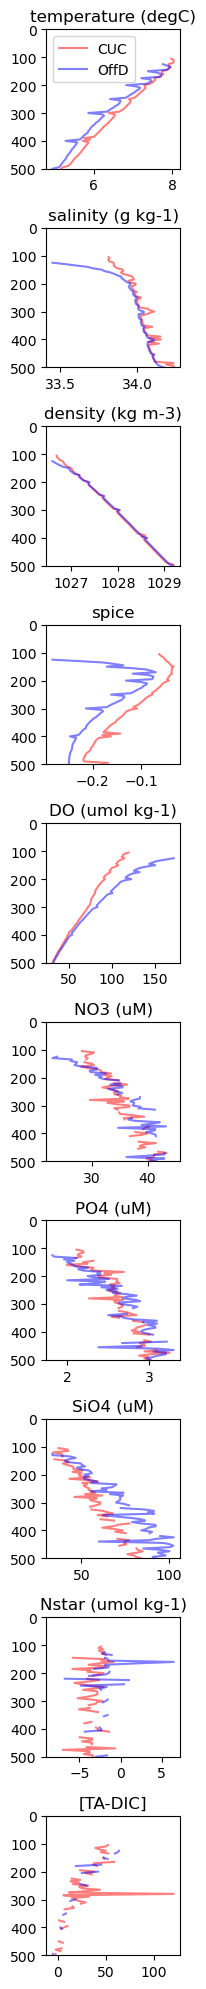

In [38]:
# property distribution with depth

fig, ax = plt.subplots(len(properties),1, figsize= (2,len(properties)*2))

for i in range(len(properties)):
    ax[i].plot(Dcuc[properties[i]],dbins[1:],alpha=0.5,color='red',label='CUC')
    ax[i].plot(Doff[properties[i]],dbins[1:],alpha=0.5,color='blue',label='OffD')
    ax[i].set_title(properties[i])
    ax[i].set_ylim([500,0])
ax[0].legend()

plt.tight_layout()

### lat binning

In [44]:
latbins =  np.linspace(40,50.8,17)

In [46]:
latcuc = cuc
latcuc["lat_bin"] = pd.cut(latcuc["latitude (degrees_north)"], bins=latbins, right=False)
latcuc = latcuc.groupby("lat_bin")[properties].mean().reset_index()

latoff = off
latoff["lat_bin"] = pd.cut(latoff["latitude (degrees_north)"], bins=latbins, right=False)
latoff = latoff.groupby("lat_bin")[properties].mean().reset_index()

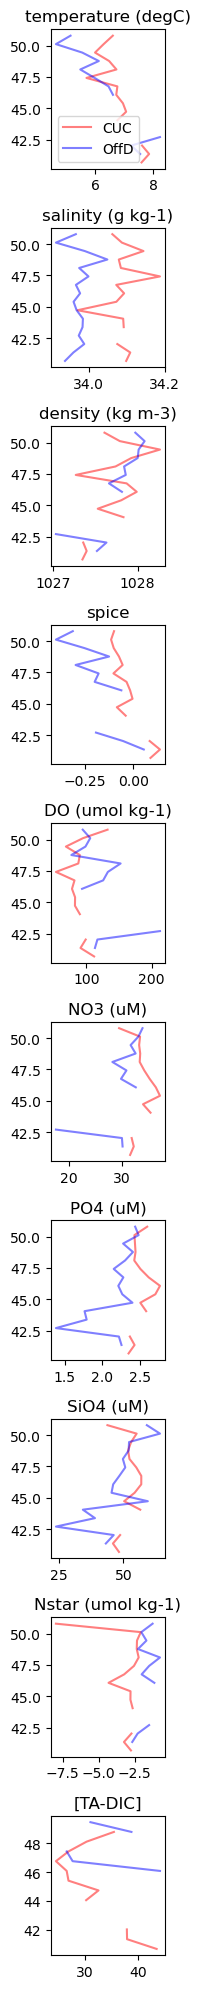

In [47]:
fig, ax = plt.subplots(len(properties),1, figsize= (2,len(properties)*2))

for i in range(len(properties)):
    ax[i].plot(latcuc[properties[i]],latbins[1:],alpha=0.5,color='red',label='CUC')
    ax[i].plot(latoff[properties[i]],latbins[1:],alpha=0.5,color='blue',label='OffD')
    ax[i].set_title(properties[i])
    # ax[i].set_ylim([,0])
ax[0].legend()

plt.tight_layout()

### time

In [48]:
tbins = np.arange(1930,2023,10)

In [56]:
cuc['year']=[time.year for time in cuc.time]
off['year']=[time.year for time in off.time]


In [57]:
tcuc = cuc
tcuc["year_bin"] = pd.cut(tcuc["year"], bins=tbins, right=False)
tcuc = tcuc.groupby("year_bin")[properties].mean().reset_index()

toff = off
toff["year_bin"] = pd.cut(toff["year"], bins=tbins, right=False)
toff = toff.groupby("year_bin")[properties].mean().reset_index()

In [59]:
tbins

array([1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020])

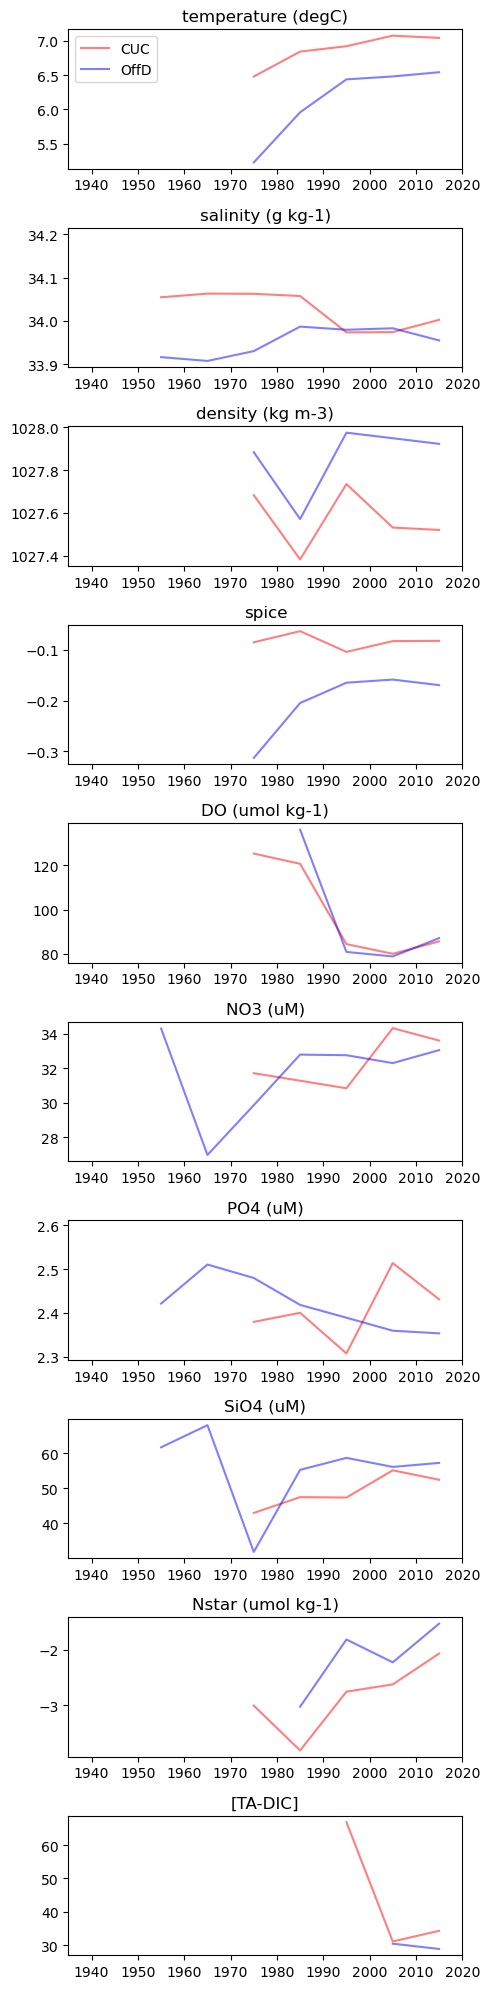

In [61]:
fig, ax = plt.subplots(len(properties),1, figsize= (5,len(properties)*2))

for i in range(len(properties)):
    ax[i].plot(tbins[1:]-5,tcuc[properties[i]],alpha=0.5,color='red',label='CUC')
    ax[i].plot(tbins[1:]-5,toff[properties[i]],alpha=0.5,color='blue',label='OffD')
    ax[i].set_title(properties[i])
    ax[i].set_xlim([1935,2020])
ax[0].legend()

plt.tight_layout()

# stats
of depth looked like the biggest difference maker - what happens to our statistics if we only look at the CUC and Off-D between 100 and 300 m?

In [63]:
# first the full range 

all_prop= ['temperature (degC)', 'salinity (g kg-1)', 'DO (umol kg-1)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)',
       'TA (umol/kg)', 'DIC (umol/kg)', 'Carbonate (umol/kg)', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)',
       'Mn (nmol kg-1)', 'Ni (nmol kg-1)', 'Zn (nmol kg-1)','Nstar (uM)', 
       'spice', 'density (kg m-3)']

for prop in all_prop:
    # print in the same format as a latex table
    print('{}: CUC = {} ({}), Off-D = {} ({}) \\'.format(prop,
                np.round(np.nanmean(cuc[prop]),1),np.round(np.nanstd(cuc[prop]),1),
                np.round(np.nanmean(off[prop]),1),np.round(np.nanstd(off[prop]),1)))

temperature (degC): CUC = 7.0 (0.9), Off-D = 6.4 (1.1) \
salinity (g kg-1): CUC = 34.0 (0.1), Off-D = 34.0 (0.2) \
DO (umol kg-1): CUC = 82.9 (33.2), Off-D = 84.0 (41.2) \
NO3 (uM): CUC = 33.4 (5.2), Off-D = 32.4 (6.9) \
NO2 (uM): CUC = 0.1 (0.1), Off-D = 0.0 (0.0) \
NH4 (uM): CUC = 0.1 (0.2), Off-D = 0.0 (0.1) \
PO4 (uM): CUC = 2.4 (0.4), Off-D = 2.4 (0.5) \
SiO4 (uM): CUC = 52.4 (15.5), Off-D = 58.2 (20.8) \
Chl (mg m-3): CUC = 0.0 (0.1), Off-D = 0.1 (0.2) \
TA (umol/kg): CUC = 2268.7 (21.3), Off-D = 2268.5 (24.0) \
DIC (umol/kg): CUC = 2234.6 (45.1), Off-D = 2239.7 (48.6) \
Carbonate (umol/kg): CUC = 59.0 (10.6), Off-D = 57.3 (10.5) \
Aragonite: CUC = 0.8 (0.2), Off-D = 0.8 (0.2) \
Calcite: CUC = 1.3 (0.3), Off-D = 1.2 (0.3) \
Cd (nmol kg-1): CUC = 0.7 (0.2), Off-D = 0.8 (0.2) \
Co (nmol kg-1): CUC = 14.2 (30.6), Off-D = 47.9 (17.6) \
Cu (nmol kg-1): CUC = 1.5 (0.4), Off-D = 1.9 (0.4) \
Fe (nmol kg-1): CUC = 1.6 (1.5), Off-D = 0.7 (0.7) \
Mn (nmol kg-1): CUC = 1.5 (0.9), Off-D = 0.7

In [67]:
# less than 300 m 

all_prop= ['temperature (degC)', 'salinity (g kg-1)', 'DO (umol kg-1)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)',
       'TA (umol/kg)', 'DIC (umol/kg)', 'Carbonate (umol/kg)', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)',
       'Mn (nmol kg-1)', 'Ni (nmol kg-1)', 'Zn (nmol kg-1)','Nstar (uM)', 
       'spice', 'density (kg m-3)']

for prop in all_prop:
    # print in the same format as a latex table
    print('{}: CUC = {} ({}), Off-D = {} ({}) \\'.format(prop,
                np.round(np.nanmean(cuc[prop][cuc['depth (m)']<300]),1),np.round(np.nanstd(cuc[prop][cuc['depth (m)']<300]),1),
                np.round(np.nanmean(off[prop][off['depth (m)']<300]),1),np.round(np.nanstd(off[prop][off['depth (m)']<300]),1)))

temperature (degC): CUC = 7.4 (0.7), Off-D = 7.1 (1.0) \
salinity (g kg-1): CUC = 34.0 (0.1), Off-D = 33.9 (0.2) \
DO (umol kg-1): CUC = 92.8 (31.3), Off-D = 115.2 (34.4) \
NO3 (uM): CUC = 31.8 (4.2), Off-D = 30.5 (6.1) \
NO2 (uM): CUC = 0.1 (0.1), Off-D = 0.0 (0.0) \
NH4 (uM): CUC = 0.1 (0.2), Off-D = 0.0 (0.1) \
PO4 (uM): CUC = 2.3 (0.3), Off-D = 2.2 (0.4) \
SiO4 (uM): CUC = 46.7 (10.2), Off-D = 51.2 (16.0) \
Chl (mg m-3): CUC = 0.0 (0.1), Off-D = 0.1 (0.1) \
TA (umol/kg): CUC = 2260.7 (15.8), Off-D = 2255.7 (15.0) \
DIC (umol/kg): CUC = 2218.4 (36.3), Off-D = 2212.6 (31.9) \
Carbonate (umol/kg): CUC = 62.3 (9.8), Off-D = 64.2 (7.7) \
Aragonite: CUC = 0.9 (0.2), Off-D = 0.9 (0.1) \
Calcite: CUC = 1.3 (0.2), Off-D = 1.3 (0.2) \
Cd (nmol kg-1): CUC = 0.7 (0.2), Off-D = 0.8 (0.1) \
Co (nmol kg-1): CUC = 14.2 (30.6), Off-D = 48.8 (17.5) \
Cu (nmol kg-1): CUC = 1.5 (0.4), Off-D = 1.8 (0.5) \
Fe (nmol kg-1): CUC = 1.6 (1.5), Off-D = 0.5 (0.6) \
Mn (nmol kg-1): CUC = 1.5 (0.9), Off-D = 0.6 

In [66]:
alpha = 0.05

for prop in all_prop:
    print(prop)
    # Filter out NaN values and exclude 'none' and 'brackish' regions
    obs_filtered = obs.dropna(subset=[prop])
    obs_filtered = obs_filtered[~obs_filtered['region'].isin(['none', 'brackish','north','south','offshore surface'])]

    # Perform one-way ANOVA
    groups = [obs_filtered[obs_filtered['region'] == region][prop] for region in ['cuc', 'offshore deep']]
    anova_result = stats.f_oneway(*groups)

    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Perform Tukey HSD test for post hoc analysis
        tukey_result = pairwise_tukeyhsd(endog=obs_filtered[prop], groups=obs_filtered['region'], alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0]).drop(['p-adj','lower','upper'],axis=1)
        
        # Calculate Cohen's d and OVL for each pair of regions
        additional_results = []
        for i, row in tukey_df.iterrows():
            region1, region2 = row['group1'], row['group2']
            data1 = obs_filtered[obs_filtered['region'] == region1][prop]
            data2 = obs_filtered[obs_filtered['region'] == region2][prop]
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            # Overlap Coefficient (OVL) calculation
            overlap_coef = 2 * stats.norm.cdf(-abs(cohens_d) / 2) if not np.isnan(cohens_d) else np.nan
            
            additional_results.append((cohens_d, overlap_coef))
        
        # Add Cohen's d and OVL to the DataFrame
        tukey_df[['Cohen\'s d', 'OVL']] = additional_results
        print("Tukey HSD post hoc results with Cohen's d and OVL:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')

temperature (degC)
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d and OVL:
  group1         group2  meandiff  reject  Cohen's d       OVL
0    cuc  offshore deep   -0.6317    True   0.623621  0.755184


salinity (g kg-1)
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d and OVL:
  group1         group2  meandiff  reject  Cohen's d       OVL
0    cuc  offshore deep   -0.0359    True   0.209957  0.916393


DO (umol kg-1)
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d and OVL:
  group1         group2  meandiff  reject  Cohen's d       OVL
0    cuc  offshore deep    1.0946    True  -0.029238  0.988336


NO3 (uM)
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d and OVL:
  group1         group2  meandiff  reject  Cohen's d       

In [70]:
alpha = 0.05

for prop in all_prop:
    print(prop)
    # Filter out NaN values and exclude 'none' and 'brackish' regions
    obs_filtered = obs[obs['depth (m)']<300].dropna(subset=[prop])
    obs_filtered = obs_filtered[~obs_filtered['region'].isin(['none', 'brackish','north','south','offshore surface'])]

    # Perform one-way ANOVA
    groups = [obs_filtered[obs_filtered['region'] == region][prop] for region in ['cuc', 'offshore deep']]
    anova_result = stats.f_oneway(*groups)

    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Perform Tukey HSD test for post hoc analysis
        tukey_result = pairwise_tukeyhsd(endog=obs_filtered[prop], groups=obs_filtered['region'], alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0]).drop(['p-adj','lower','upper'],axis=1)
        
        # Calculate Cohen's d and OVL for each pair of regions
        additional_results = []
        for i, row in tukey_df.iterrows():
            region1, region2 = row['group1'], row['group2']
            data1 = obs_filtered[obs_filtered['region'] == region1][prop]
            data2 = obs_filtered[obs_filtered['region'] == region2][prop]
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            # Overlap Coefficient (OVL) calculation
            overlap_coef = 2 * stats.norm.cdf(-abs(cohens_d) / 2) if not np.isnan(cohens_d) else np.nan
            
            additional_results.append((cohens_d, overlap_coef))
        
        # Add Cohen's d and OVL to the DataFrame
        tukey_df[['Cohen\'s d', 'OVL']] = additional_results
        print("Tukey HSD post hoc results with Cohen's d and OVL:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')

temperature (degC)
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d and OVL:
  group1         group2  meandiff  reject  Cohen's d       OVL
0    cuc  offshore deep   -0.2642    True   0.303394  0.879426


salinity (g kg-1)
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d and OVL:
  group1         group2  meandiff  reject  Cohen's d       OVL
0    cuc  offshore deep   -0.0824    True   0.450808  0.821665


DO (umol kg-1)
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d and OVL:
  group1         group2  meandiff  reject  Cohen's d       OVL
0    cuc  offshore deep   22.3178    True  -0.678306  0.734494


NO3 (uM)
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d and OVL:
  group1         group2  meandiff  reject  Cohen's d       

Cases where the decrease in depth interval decreases the similarity of cuc and offshore deep (increased Cohen's d and decreased OVL):<br>
salinity, DO, NO3, NO2, PO4, SiO4, Co, Fe, Mn, <br>
notably temperature, spice, and density get worse <br>
Previously did not have a significant difference and now does: <br>
TA <br>
Previously had a significant difference and now doesn't:<br>
Cd, Zn 